In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split
import pandas as pd
import data_pecarn 
import data_psrc
import data
from collections import Counter
plt.style.use('dark_background')
# sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

In [10]:
dummy = False
df_pecarn = data_pecarn.get_data(use_processed=False,
                                 frac_missing_allowed=0.1,
                                 dummy=dummy)
all_feats_pecarn, filtered_feats_pecarn = data.get_feat_names(df_pecarn)
df_psrc = data_psrc.get_data(use_processed=False, dummy=dummy)
all_feats_psrc, filtered_feats_psrc = data.get_feat_names(df_psrc)

computing pecarn preprocessing...
computing psrc preprocessing...


# still need to find all the rel vars for distracting pain

In [8]:
outcome_def = 'iai_intervention' # output
common_feats = list(filtered_feats_pecarn.intersection(filtered_feats_psrc))
common_feats = common_feats + [outcome_def, 'cv_fold', 'dset']
feats_numerical = ['InitSysBPRange', 'InitHeartRate', 'GCSScore', 'Age', 'AbdTenderDegree']
feats_categorical = [feat for feat in common_feats
                     if not feat in feats_numerical
                     and not feat in ['dset', 'cv_fold', 'iai_intervention', 'Race', 'RecodedMOI']]
print(common_feats, len(common_feats))

['AbdDistention', 'InitHeartRate', 'Race', 'Age', 'AbdTenderDegree', 'InitSysBPRange', 'DecrBreathSound', 'AbdomenPain', 'RecodedMOI', 'AbdTrauma', 'GCSScore', 'AbdTrauma_or_SeatBeltSign', 'Hypotension', 'LtCostalTender', 'DistractingPain', 'RtCostalTender', 'SeatBeltSign', 'VomitWretch', 'CostalTender', 'ThoracicTrauma', 'iai_intervention', 'cv_fold', 'dset'] 23


In [ ]:
for feat in common_feats:
    print(feat, df_pecarn[feat].unique(),
          df_pecarn[feat].min(), df_pecarn[feat].max())

**look at resulting feats**

In [133]:
filtered_feats_pecarn.intersection(filtered_feats_psrc)

{'AbdDistention',
 'AbdTenderDegree',
 'AbdTrauma',
 'AbdTrauma_or_SeatBeltSign',
 'AbdomenPain',
 'Age',
 'CostalTender',
 'DecrBreathSound',
 'DistractingPain',
 'GCSScore',
 'Hypotension',
 'InitHeartRate',
 'InitSysBPRange',
 'LtCostalTender',
 'Race',
 'RecodedMOI',
 'RtCostalTender',
 'SeatBeltSign',
 'ThoracicTrauma',
 'VomitWretch'}

In [134]:
print('psrc but not pecarn')
filtered_feats_psrc.difference(filtered_feats_pecarn)

psrc but not pecarn


{'FemurFracture'}

In [135]:
print('pecarn but not psrc')
print(filtered_feats_pecarn.difference(filtered_feats_psrc))

pecarn but not psrc
{'ThoracicTender'}


# look for feat shift

In [ ]:
R, C, = 3, 2
plt.figure(dpi=300)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df_pecarn[feat], density=True, alpha=0.5, label='pecarn')
    plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc')
    plt.xlabel(feat)
plt.legend()
plt.tight_layout()
plt.show()

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


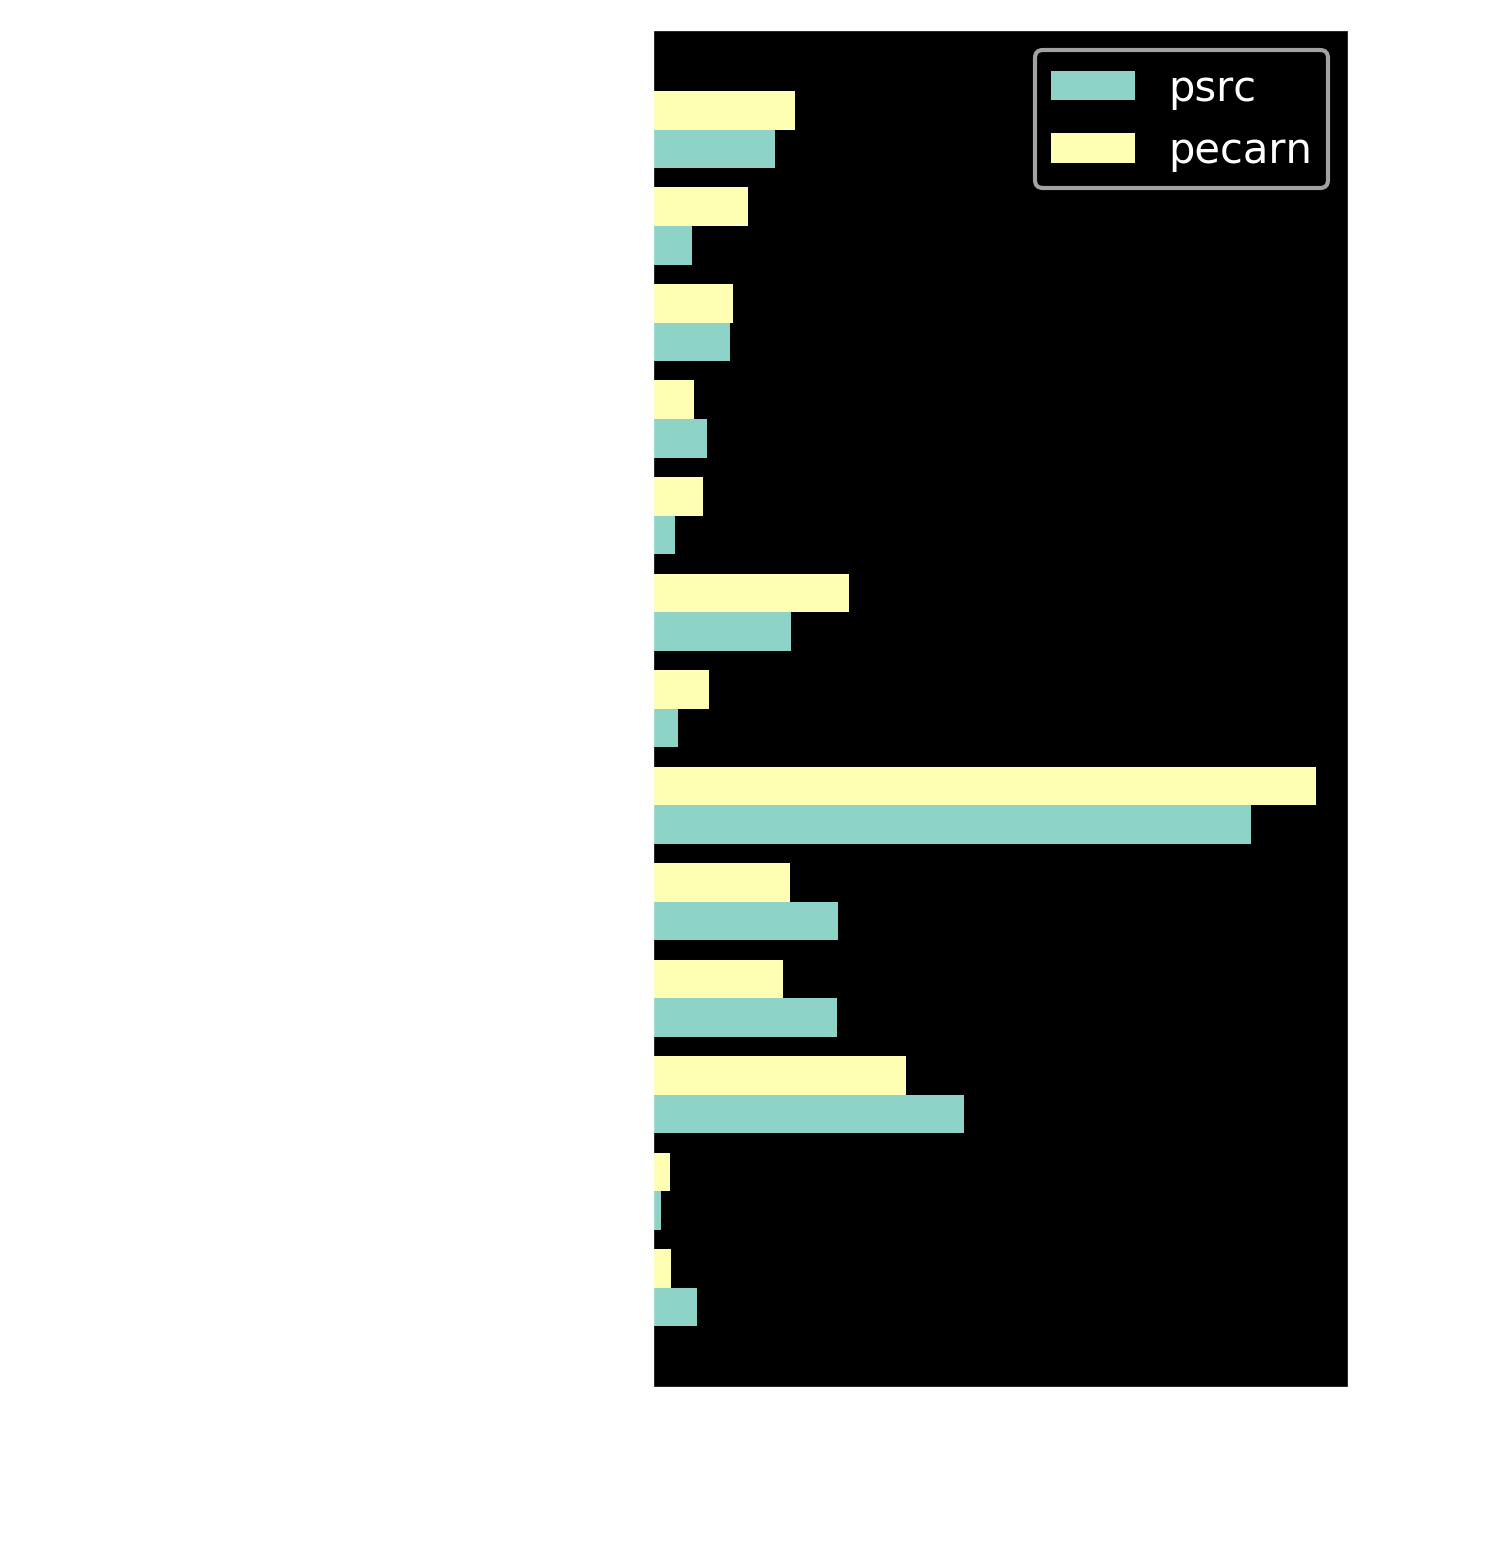

In [11]:
R, C = 3, 4
n = len(feats_categorical)
def true_or_yes(vals):
    return (vals==True) | (vals=='yes')
frac_psrc = true_or_yes(df_psrc[feats_categorical]).mean().values
frac_pecarn = true_or_yes(df_pecarn[feats_categorical]).mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn')
plt.yticks(np.arange(n) - width + 0.2, feats_categorical)
plt.xlabel('fraction of patients for which this is present')
plt.legend()
plt.show()

**missing features**

In [ ]:
R, C = 3, 4
feats_categorical = [feat for feat in common_feats
                     if not feat in feats_numerical and not feat in ['dset', 'cv_fold', 'iai_intervention']]
n = len(feats_categorical)
frac_psrc = (df_psrc[feats_categorical]=='unknown').mean().values
frac_pecarn = (df_pecarn[feats_categorical]=='unknown').mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn')
plt.yticks(np.arange(n) - width + 0.2, feats_categorical)

plt.legend()
plt.show()

# write csvs

In [23]:
df_pecarn.astype('object').describe().transpose().to_csv('processed/pecarn_vars.csv')
df_psrc.astype('object').describe().transpose().to_csv('processed/psrc_vars.csv')

In [117]:
common_feats = [x for x in feat_names_pecarn if x in feat_names_psrc]

In [17]:
df_psrc['Emesis post injury'].unique()

array([ 0., nan,  1.])